In [8]:
# setup Colabs
!pip install brian2


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


<h2>Engram Formation</h2>
This notebook grows a network and then stimulates a subpopulation.<br>
The connectivity of the stimulated and an unstimulated population are recorded, to observe engram formation.<br>
<br>
Due note that running the full size simulation takes some time(~5h), so we reduced the network size for testing.

In [2]:
from brian2 import *
from models import StructuralPlasticityModel
set_device("cpp_standalone", build_on_run=False)
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
params = {'order': 2500, 'eps':0.1, 'enable_plasticity': True, 'tau_ca': 10*second, 'nu_ext_mult': 1.1, 'standalone' : True}
prefs.devices.cpp_standalone.openmp_threads = 16

In [10]:
from models import StructuralPlasticityModel

device.reinit()
device.activate(build_on_run=False)

print(defaultclock.dt)

#defaultclock.dt = 0.1*ms

model = StructuralPlasticityModel(params)

# Record neuron variables

subpop_size = int(model.N_E * 0.1)

state_mon_E1 = StateMonitor(model.E[:subpop_size], ['phi', 'a', 'd'], dt=10*second, record=True)
state_mon_E2 = StateMonitor(model.E[subpop_size:], ['phi', 'a', 'd'], dt=10*second, record=True)
spike_mon_E1 = SpikeMonitor(model.E[:subpop_size])
spike_mon_E2 = SpikeMonitor(model.E[subpop_size:])
spike_mon_I = SpikeMonitor(model.I)
model.network.add(state_mon_E1, state_mon_E2, spike_mon_E1, spike_mon_E2, spike_mon_I)

if(True):
    state_mon_con = StateMonitor(model.ConMean, ['c_1_1', 'c_1_2', 'c_2_1', 'c_2_2'], dt=10*second, record=True)
    model.network.add(state_mon_con)
else:
    # set up recording of subpopulation connectivity
    C_E_1_1_t = []
    C_E_1_1 = []
    C_E_2_2_t = []
    C_E_2_2 = []
    C_E_1_2_t = []
    C0
    def record_connectivity_subpop(t):
        con = model.S_E_E.c.variable.get_value().reshape(model.N_E, model.N_E)
        C_E_1_1_t.append(t/ms)
        C_E_1_1.append(mean(con[:subpop_size, :subpop_size]))
        C_E_1_2_t.append(t/ms)
        C_E_1_2.append(mean(con[:subpop_size, subpop_size:]))
        C_E_2_1_t.append(t/ms)
        C_E_2_1.append(mean(con[subpop_size:, :subpop_size]))
        C_E_2_2_t.append(t/ms)
        C_E_2_2.append(mean(con[subpop_size:, subpop_size:]))
    
    rec = NetworkOperation(record_connectivity_subpop, dt=10*second)
    model.network.add(rec)

dur_grow = 500*second
dur_stim = 150*second
dur_rest = 500*second

#state_mon_c = StateMonitor(model.S_E_E, 'c',dt=10*second, record=arange(0, model.N_E**2))
#model.network.add(state_mon_c)

M = PopulationRateMonitor(model.E)
model.network.add(M)

# Run stimulation experiment
model.run(dur_grow, profile=True)

# Stimulate network with increased external input
P_E_1_stim = PoissonInput(model.E[:1000], rate=(model.nu_ext*params['nu_ext_mult'])/15, target_var='v', N=15, weight=model.J)
model.P_E_1.active = False
model.network.add(P_E_1_stim)
#model.E.nu_ext[:subpop_size] = ((model.nu_ext)/kHz) * params['nu_ext_mult']
model.run(dur_stim, profile=True)

# Continue with base stimulation
P_E_1_stim.active=False
model.P_E_1.active = True
#model.E.nu_ext = (model.nu_ext)/kHz
model.run(dur_rest, profile=True)

device.build(directory='output', compile=False, run=False, debug=False)


100. us
standalone


In [11]:
print(defaultclock.dt)
compiler, _  = codegen.cpp_prefs.get_compiler_and_args()
device.compile_source('output', compiler, False, False)
device.run('output', True, [])
print(profiling_summary())

100. us
Starting simulation at t=0 s for duration 500 s
10.9145 s (2%) simulated in 20s, estimated 14m 56s remaining.
22.1775 s (4%) simulated in 40s, estimated 14m 22s remaining.
33.488 s (6%) simulated in 1m 0s, estimated 13m 56s remaining.
44.8 s (8%) simulated in 1m 20s, estimated 13m 33s remaining.
55.9659 s (11%) simulated in 1m 40s, estimated 13m 13s remaining.
67.2 s (13%) simulated in 2m 0s, estimated 12m 53s remaining.
78.2 s (15%) simulated in 2m 20s, estimated 12m 35s remaining.
89.4 s (17%) simulated in 2m 40s, estimated 12m 15s remaining.
100.4 s (20%) simulated in 3m 0s, estimated 11m 57s remaining.
111.484 s (22%) simulated in 3m 20s, estimated 11m 37s remaining.
122.3 s (24%) simulated in 3m 40s, estimated 11m 20s remaining.
133.175 s (26%) simulated in 4m 0s, estimated 11m 1s remaining.
144 s (28%) simulated in 4m 20s, estimated 10m 43s remaining.
154.9 s (30%) simulated in 4m 40s, estimated 10m 24s remaining.
165.686 s (33%) simulated in 5m 0s, estimated 10m 5s remai

In [12]:
params_str = ''
for k, v in params.items():
    params_str += '_' + str(k) + '_' + str(v)
#np.savez('Experiments/con' + params_str, C_E_1_1_t=C_E_1_1_t, C_E_1_1=C_E_1_1, C_E_1_2_t=C_E_1_2_t, C_E_1_2=C_E_1_2, C_E_2_1_t=C_E_2_1_t, C_E_2_1=C_E_2_1, C_E_2_2_t=C_E_2_2_t, C_E_2_2=C_E_2_2)
np.savez('Experiments/con' + params_str, C_E_1_1_t=state_mon_con.t/ms, C_E_1_1=state_mon_con.c_1_1[0], 
    C_E_1_2_t=state_mon_con.t/ms, C_E_1_2=state_mon_con.c_1_2[0], 
    C_E_2_1_t=state_mon_con.t/ms, C_E_2_1=state_mon_con.c_2_1[0], 
    C_E_2_2_t=state_mon_con.t/ms, C_E_2_2=state_mon_con.c_2_2[0])
np.savez('Experiments/state'+ params_str, 
t=state_mon_E1.t/ms, phi_E1=state_mon_E1.phi, a_E1=state_mon_E1.a, d_E1=state_mon_E1.d, 
t2=state_mon_E2.t/ms, phi_E2=state_mon_E2.phi, a_E2=state_mon_E2.a, d_E2=state_mon_E2.d
)
np.savez('Experiments/spikes' + params_str, t=spike_mon_E1.t/ms, i=spike_mon_E1.i, t2=spike_mon_E2.t/ms, i2=spike_mon_E2.i, t3=spike_mon_I.t/ms, i3=spike_mon_I.i)
np.savez('Experiments/rate' + params_str, t=M.t/ms, rate=M.smooth_rate(width=1*second)/Hz)

In [13]:
def plot_experiment(experiment_name):
    con = np.load('Experiments/con' + experiment_name + '.npz')
    state = np.load('Experiments/state' + experiment_name + '.npz')
    spikes = np.load('Experiments/spikes' + experiment_name + '.npz')
    rate = np.load('Experiments/rate' + experiment_name + '.npz')
    #list_tate['d_E2'], axis=0), label='elems_E2', color='blue')
    
    fig, axs = plt.subplots(5, 1, figsize=(9, 16))
    
    e_1_i_100 = spikes['i'][spikes['i'] < 30]
    e_1_t_100 = spikes['t'][spikes['i'] < 30]
    
    e_2_i_100 = spikes['i2'][spikes['i2'] < 30]
    e_2_t_100 = spikes['t2'][spikes['i2'] < 30]

    i_i_100 = spikes['i3'][spikes['i3'] < 30]
    i_t_100 = spikes['t3'][spikes['i3'] < 30]
    
    axs[0].plot(e_1_t_100, e_1_i_100, ',', label='E1', color='green')
    axs[0].plot(e_2_t_100, e_2_i_100 + 30, ',', label='E2', color='blue')
    axs[0].plot(i_t_100, i_i_100 + 60, ',', label='I', color='red')
    #axs[0].plot(spikes['t'], spikes['i'], ',', label='E1', color='green')
    #axs[0].plot(spikes['t2'], spikes['i2'] + 1000, ',', label='E2', color='blue')
    #axs[0].plot(spikes['t3'], spikes['i3'] + 10000, ',', label='I', color='red')
    
    axs[1].plot(state['t']/1000, np.mean(state['phi_E1'], axis=0), '.', label='phi_E1', color='green')
    axs[1].plot(state['t2']/1000, np.mean(state['phi_E2'], axis=0), '.', label='phi_E2', color='blue')
    
    axs[2].plot(state['t']/1000, np.mean(state['d_E1'], axis=0), '.', label='d_E1', color='green')
    axs[2].plot(state['t2']/1000, np.mean(state['d_E2'], axis=0), '.', label='d_E2', color='blue')

    axs[3].plot(np.array(con['C_E_1_2_t'])/1000, con['C_E_1_2'], '.', label='C_1_2', color='darkgrey')
    axs[3].plot(np.array(con['C_E_2_1_t'])/1000, con['C_E_2_1'], '.', label= 'C_2_1', color='darkgrey')
    axs[3].plot(np.array(con['C_E_1_1_t'])/1000, con['C_E_1_1'], '.', label='C_1_1', color = 'green')
    axs[3].plot(np.array(con['C_E_2_2_t'])/1000, con['C_E_2_2'], '.', label= 'C_2_2', color= 'blue')
    
    axs[4].plot(rate['t']/1000, rate['rate'], label='rate', color='black')
    
    return fig, axs

In [14]:
import h5py

# load analytical data from original paper (created with mathematica) 
# and add to existing plot
def plot_analysis(filename, fig, axs):
    f = h5py.File(filename, 'r')
    dset = f['Dataset1']

    phi_E1 = dset[:11501, 2]
    phi_E2 = dset[:11501, 3]
    
    C_E_1_1 = dset[:11501, 4]
    C_E_1_2 = dset[:11501, 5]
    C_E_2_1 = dset[:11501, 6]
    C_E_2_2 = dset[:11501, 7]

    axs[1].plot(np.arange(0, 11501)/10, phi_E1, label='phi_E1', color='green')
    axs[1].plot(np.arange(0, 11501)/10, phi_E2, label='phi_E2', color='blue')

    axs[3].plot(np.arange(0, 11501)/10, C_E_1_1, label='C_1_1', color='green')
    axs[3].plot(np.arange(0, 11501)/10, C_E_2_2, label='C_2_2', color='blue')
    axs[3].plot(np.arange(0, 11501)/10, C_E_1_2, label='C_1_2', color='darkgrey')
    axs[3].plot(np.arange(0, 11501)/10, C_E_2_1, label='C_2_1', color='darkgrey')



WARNING    /tmp/ipykernel_10148/501717296.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
 [py.warnings]


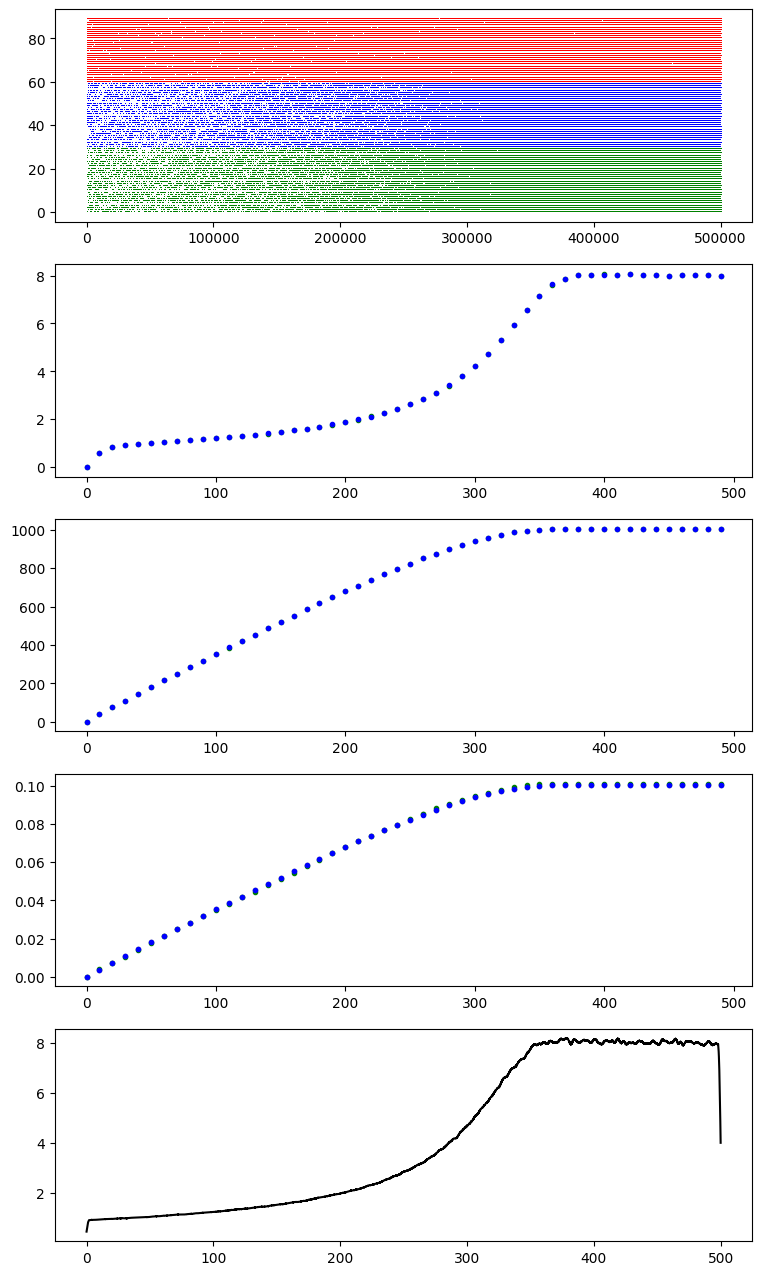

In [15]:
params_str = ''
for k, v in params.items():
    params_str += '_' + str(k) + '_' + str(v)

fig, axs = plot_experiment(params_str)
    
#plot_analysis('./tracesnaive.h5', fig, axs)

fig.show()
    

    

In [36]:
imsave('s_e_e_c.png', model.S_E_E.c[:].reshape(model.N_E, model.N_E))
#mean(model.S_E_E.c[:].reshape(model.N_E, model.N_E))